In [152]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
import time

In [153]:
"""Subtractive Clustering Algorithm
"""

def SubstractiveClustering(data, Ra, Rb, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

In [154]:
"""
Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.
"""


def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

######################################################################

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

#################################################################################################################

# ESTA EDITADO EL DEF VIEW PARA AGRANDAR EL ESPACIO EN X EN EL GRAFICO

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        #x = np.linspace(self.minValue -400,self.maxValue + 400,30)

        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

##################################################################################################################

# Se genera la clase Fis (sugeno)
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        self.solutions=[]


###################################################################################################################
    
    def genfis(self, data, labels, cluster_center):

        start_time = time.time()
        #labels, cluster_center = SubstactiveClustering(data, radii) se quita porque el clustering lo hacemos afuera para hacerlo variar a nuestro criterio
        
        n_clusters = len(cluster_center)
        cluster_center = cluster_center[:,:-1]

        varInput = data[:,:-1]
        # Se obtienen las variables de entrada P a partir de los datos de entrada data. Luego,
        #  se calculan los valores máximos (maxValue) y mínimos (minValue) de cada variable de entrada.

        #T = data[:,-1]
        maxValue = np.max(varInput, axis=0)
        minValue = np.min(varInput, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        #  Se crea una lista de objetos fisInput para cada variable de entrada. Cada objeto fisInput se inicializa con su valor máximo, mínimo y
        #  los centroides de los clusters correspondientes a esa variable.
        self.rules = cluster_center
        self.entrenar(data)

######################################################################################################################
    def entrenar(self, data):
        varInput = data[:,:-1] #hace esa anotacion fea porque porque queda mejor los datos presentados
        varOuput = data[:,-1]
# P contiene las variables de entrada del conjunto de datos data.
# T contiene las salidas deseadas (target) del conjunto de datos data.
        
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs]) 
        #Aquí se calcula la desviación estándar sigma para las funciones de membresía gaussianas utilizadas en el sistema Sugeno.
        #  self.inputs contiene información sobre las variables de entrada.
        
        f = [np.prod(gaussmf(varInput,cluster,sigma),axis=1) for cluster in self.rules]
        #  Activación de cada regla para cada conjunto de entrada.
        #  Esto se hace multiplicando las funciones de membresía gaussianas por cada regla y luego tomando el producto.
        #  El resultado es una lista de valores de activación para cada regla y cada instancia de entrada.

        nivel_acti = np.array(f).T
        #  nivel_acti es una matriz donde cada fila corresponde a una instancia del conjunto de datos y cada columna corresponde a una regla.
        #  Contiene los valores de activación de cada regla para cada instancia.


        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        # sumMu es un vector que contiene la suma de los valores de activación para cada instancia. 
        # Esto se usa en el cálculo de los coeficientes del sistema Sugeno.
        varInput = np.c_[varInput, np.ones(len(varInput))]
        n_vars = varInput.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = varInput[:, orden]
        # Aquí se preparan los datos para el cálculo de los coeficientes. Se añade una columna de unos a la matriz P, 
        # luego se calculan las matrices acti e inp que se utilizan para construir la matriz de coeficientes A.
        


        A = acti*inp/sumMu
        #A es la matriz de coeficientes que se utiliza en el sistema de ecuaciones lineales.

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        solutions, residuals, rank, s = np.linalg.lstsq(A,varOuput,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        #Se resuelve el sistema de ecuaciones lineales utilizando mínimos cuadrados y se almacenan las soluciones en self.solutions.
        print(solutions)
        return 0


###############################################################################################################
    
    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)

#  En resumen, este tramo toma un conjunto de datos de entrada y utiliza el sistema Sugeno previamente entrenado para calcular las salidas correspondientes.
#  este método asume que las variables de entrada y las reglas ya están configuradas en la instancia de la clase fis y
#  que los coeficientes del sistema Sugeno se han calculado previamente durante el entrenamiento


#################################################################################################################

    def viewInputs(self):
        for input in self.inputs:
            input.view()






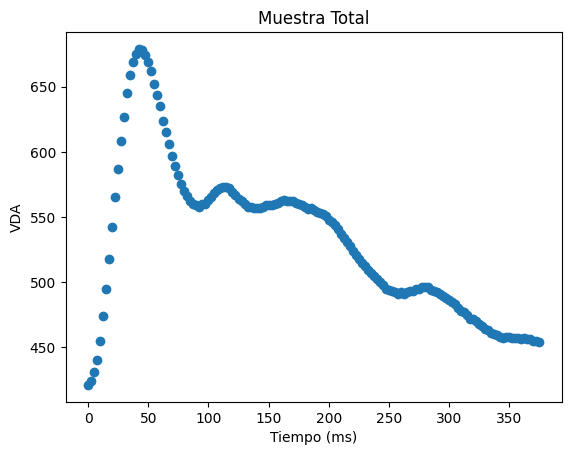

In [155]:
'''                                 MODULO DE LECTURA DE ARCHIVO                                      '''

from sklearn.model_selection import train_test_split
import numpy as np

# Cargar los datos desde el archivo de texto
vda = np.loadtxt("/home/mikel/Documents/Facultad/IA/tp-ia/samplesVDA1.txt")
cant_datos = vda.shape[0]
medidas_x_segundo = 400 
npyarray=np.array
tiempo = np.arange(0,cant_datos/400,1/medidas_x_segundo)
tiempo = tiempo*1000

data_y = vda.reshape(-1,1) 
data_x = tiempo.reshape(-1,1)

##esto es modificable
# Divide los datos en conjuntos de entrenamiento y prueba 
vda_entrenamiento, vda_prueba, tiempo_entrenamiento, tiempo_prueba = train_test_split(data_y, data_x, test_size=0.2, random_state=42) #random_state modifica la distancia entre los puntos que tomo para test.
#vda_entrenamiento, vda_prueba, tiempo_entrenamiento, tiempo_prueba = train_test_split(data_y, data_x, test_size=0.2)

dataTrain = np.hstack((tiempo_entrenamiento,vda_entrenamiento)) # datos de entrenamiento
dataTest = np.hstack((tiempo_prueba,vda_prueba)) # datos testing


#Graficamos los datos totales
plt.scatter(data_x, data_y)
plt.xlabel('Tiempo (ms)')
plt.ylabel('VDA')
plt.title('Muestra Total')
plt.show()

In [156]:
#Graficamos los datos totales



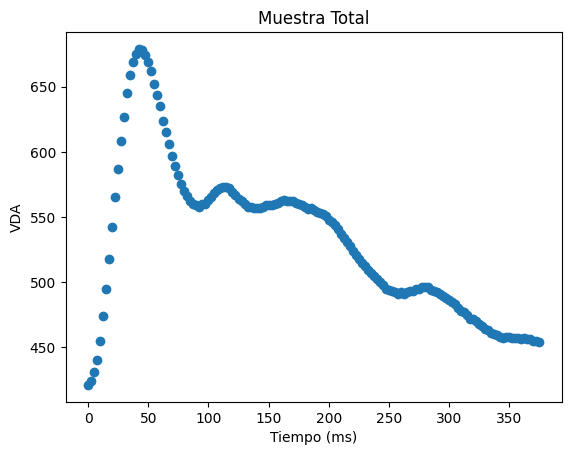

"\nplt.scatter(tiempo_prueba, vda_prueba)\nplt.xlabel('Tiempo (Milisegundos)')\nplt.ylabel('VDA')\nplt.title('puntos que tomo para hacer el test')\nplt.show()"

In [157]:
'''                                 MODULO DE GRAFICO DE DATOS                                      '''
#Grafico mmuestra total
plt.scatter(data_x, data_y)
plt.xlabel('Tiempo (ms)')
plt.ylabel('VDA')
plt.title('Muestra Total')
plt.show()

'''
plt.scatter(tiempo_prueba, vda_prueba)
plt.xlabel('Tiempo (Milisegundos)')
plt.ylabel('VDA')
plt.title('puntos que tomo para hacer el test')
plt.show()'''

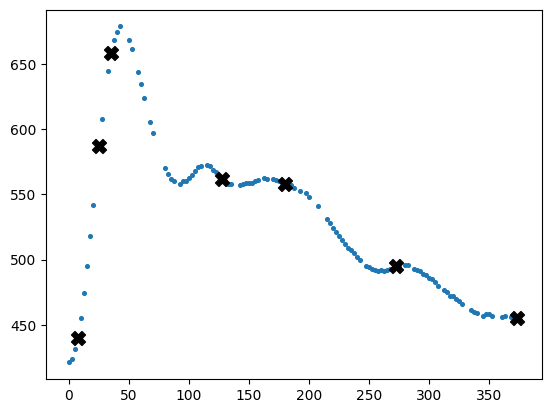

In [158]:
'''                                 MODULO DE EJECUCION Y GRAFICO DE CLUSTERING SUBSTRACTIVO          '''

labels,centers = SubstractiveClustering(dataTrain,0.5,0) #Este tenemos que modificar
plt.figure()
plt.scatter(dataTrain[:,0],dataTrain[:,1], s=7)
plt.scatter(centers[:,0],centers[:,1], marker='X',s=100,c="black")
plt.show()


[-1.39621613e+08 -4.29664932e+11 -5.59972985e+06 -5.83282487e+10
 -3.36229136e+08  1.21240411e+12  1.62906139e+09  1.05773523e+11
 -2.35535585e+09  6.11343748e+09 -2.14171093e+09 -1.18709270e+11
 -1.60904150e+09 -5.07615095e+10]


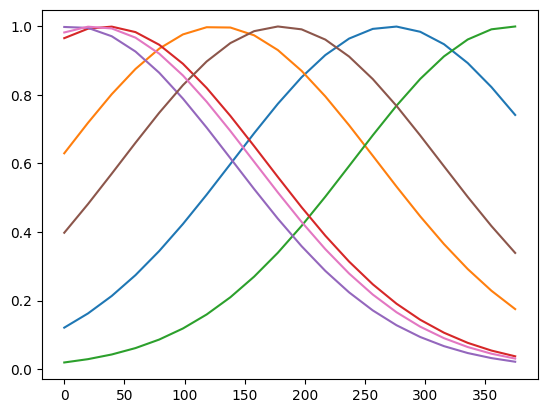

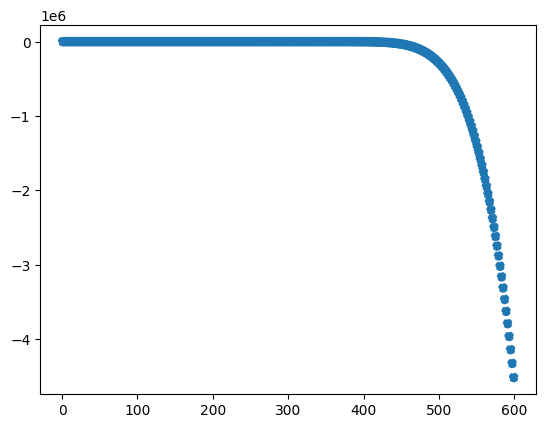

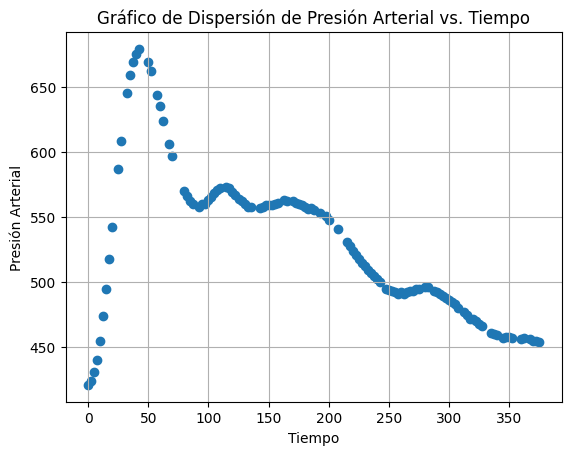

In [165]:
'''                                 MODULO DE EJECUCION Y SOLUCION DE SUGENO                           '''

fis2 = fis() # genero la clase fis, mejor llamado modelo de Sugeno
fis2.genfis(dataTrain,labels,centers)
fis2.viewInputs()#capaz podemos editar este metodo con un parametro para modificarlo desde afuera

'''                                 MODULO DE GRAFICO DE FUNCION SOLUCION DE SUGENO                           '''
arreglo = np.linspace(1, 601, 2)                            #Generamos un arreglo con numeros del 1 al 600 para el eje x a graficar
arreglo = arreglo.reshape(-1,1)
coordenadas_y= fis2.evalfis(arreglo)                                 #Generamos los valores del eje y a partir de la funcion solucion obtenida

plt.figure()
plt.scatter(arreglo,coordenadas_y,linestyle='--')
plt.show()

plt.figure()
plt.scatter(tiempo_entrenamiento,vda_entrenamiento)
plt.xlabel('Tiempo')
plt.ylabel('Presión Arterial')
plt.title('Gráfico de Dispersión de Presión Arterial vs. Tiempo')
plt.grid(True)
plt.show()
#grafico los datos que nos dieron.



In [160]:
'''                                 MODULO DE VALIDACION Y CALCULO DE ERRORES                           '''
errores = []
'''    
x = fis2.evalfis((tiempo_prueba))

for i in range(len(x)):
    resultado = x[i] - vda_prueba[i]
    print(f" error en iteracion {i}, error:  {resultado} , x = {x[i]} , vdaprueba =  {vda_prueba[i]}")
    errores.append(resultado)

errores = np.sqrt(np.square(errores))
promedio_error = np.mean(errores)

print(f"Error acumulado: {promedio_error}")
print(f"Error promedio: {np.sum(mi_arreglo)}")'''    


'    \nx = fis2.evalfis((tiempo_prueba))\n\nfor i in range(len(x)):\n    resultado = x[i] - vda_prueba[i]\n    print(f" error en iteracion {i}, error:  {resultado} , x = {x[i]} , vdaprueba =  {vda_prueba[i]}")\n    errores.append(resultado)\n\nerrores = np.sqrt(np.square(errores))\npromedio_error = np.mean(errores)\n\nprint(f"Error acumulado: {promedio_error}")\nprint(f"Error promedio: {np.sum(mi_arreglo)}")'